In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

from robustness.audio_functions.jsinV3DataLoader_precombined import *
from robustness.audio_functions.audio_transforms import *

In [2]:
example_path = "/mnt/ceph/users/jfeather/data/training_datasets_audio/JSIN_all_v3/subsets/valid_RQTTZB4C3TJJVLJUWDV72TYMC7S4MNHH/JSIN_all__run_000_RQTTZB4C3TJJVLJUWDV72TYMC7S4MNHH.h5"
example_path_dir = "/mnt/ceph/users/jfeather/data/training_datasets_audio/JSIN_all_v3/subsets"
transform = AudioCompose(
    [
        AudioToTensor(),
        CombineWithRandomDBSNR()
    ]
)
example_dset = H5Dataset(example_path, transform=transform, target_keys=['signal/word_int'])
#example_dset_paired = H5DatasetPaired(example_path, transform=transform, target_keys=['signal/word_int'])
example_dset_paired = jsinV3_precombined_paired(example_path_dir, transform=transform, train=True)

In [3]:
len(example_dset_paired) / 1024

2837.109375

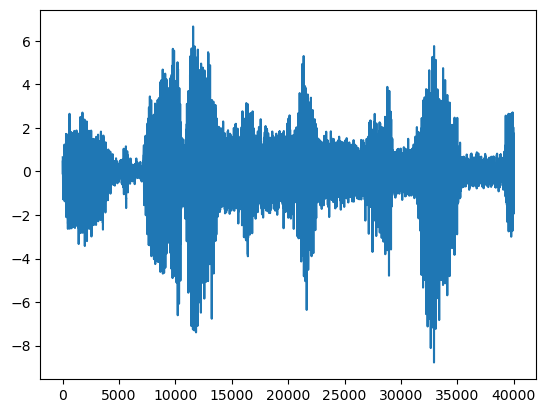

In [4]:
wave, label = example_dset.__getitem__(10)
plt.plot(wave)
Audio(wave, rate=20000)

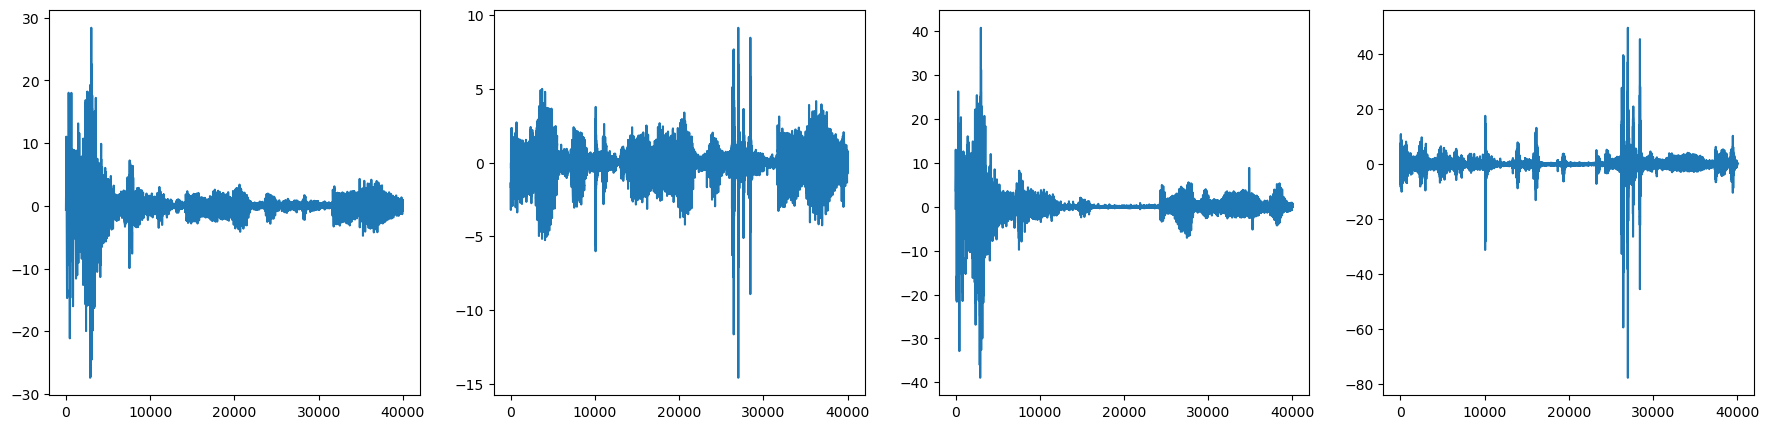

In [ ]:
wave_11, wave_12, wave_21, wave_22, label = example_dset_paired.__getitem__(10)
fig, axs = plt.subplots(1, 4, figsize=(22, 5))
axs[0].plot(wave_11)
axs[1].plot(wave_12)
axs[2].plot(wave_21)
axs[3].plot(wave_22)
Audio(wave_11, rate=20000)

In [ ]:
Audio(wave_12, rate=20000)

In [ ]:
Audio(wave_21, rate=20000)

In [ ]:
Audio(wave_22, rate=20000)

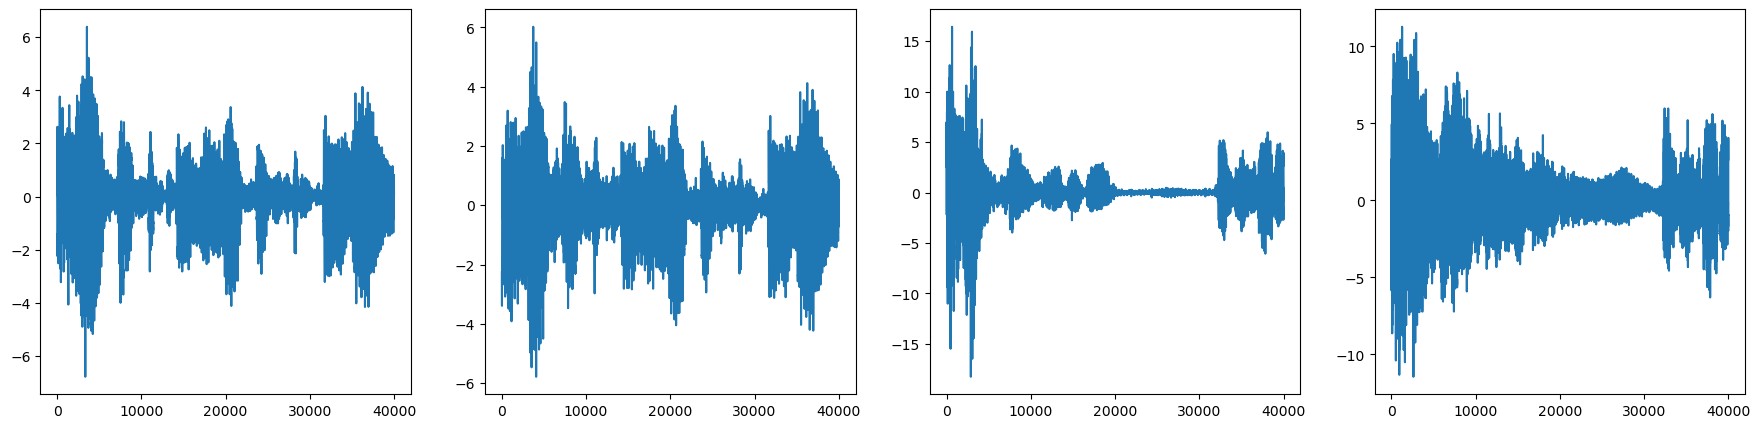

In [ ]:
example_dset_paired._rotate_splits()
wave_11, wave_12, wave_21, wave_22, label = example_dset_paired.__getitem__(10)
fig, axs = plt.subplots(1, 4, figsize=(22, 5))
axs[0].plot(wave_11)
axs[1].plot(wave_12)
axs[2].plot(wave_21)
axs[3].plot(wave_22)
Audio(wave_11, rate=20000)

In [ ]:
Audio(wave_12, rate=20000)

In [ ]:
Audio(wave_21, rate=20000)

In [ ]:
Audio(wave_22, rate=20000)

In [ ]:
len(example_dset)

16812

In [ ]:
from robustness.model_utils import make_and_restore_model
from robustness.datasets import jsinV3

In [ ]:
model = jsinV3(
    data_path='/mnt/ceph/users/jfeather/data/training_datasets_audio/JSIN_all_v3/subsets',
)

In [ ]:
loaders = model.make_loaders(workers=10, batch_size=16)

==> Preparing dataset jsinV3..
/mnt/ceph/users/jfeather/data/training_datasets_audio/JSIN_all_v3/subsets


/mnt/ceph/users/tyerxa/.venv_fmri_metamers/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_loader, test_loader = loaders

In [ ]:
x = next(iter(test_loader))

/mnt/ceph/users/tyerxa/.venv_fmri_metamers/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
inputs, labels = x
print(inputs.shape)


torch.Size([16, 1, 256, 401])


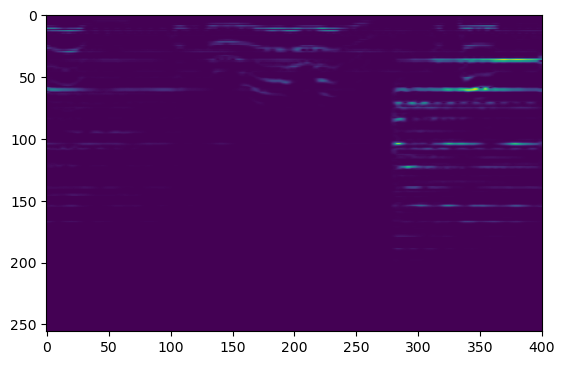

In [ ]:
batch_index = 3
plt.imshow(inputs[batch_index, 0].numpy())

In [ ]:
len(train_loader)

363163

## Simple Training Loop

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from tqdm import tqdm

import torch
from torch import nn
import torchvision
from torchvision.models.resnet import resnet50
import torch.nn.functional as F

from robustness.audio_functions.jsinV3DataLoader_precombined import *
from robustness.audio_functions.audio_transforms import *


/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/sw/nix/store/6qvrglgqdpwhbw9zv2nh07fpd7a4wq31-py-torchvision-0.15.2/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
train_path = "/mnt/ceph/users/jfeather/data/training_datasets_audio/JSIN_all_v3/subsets/valid_RQTTZB4C3TJJVLJUWDV72TYMC7S4MNHH/JSIN_all__run_000_RQTTZB4C3TJJVLJUWDV72TYMC7S4MNHH.h5"
val_path = "/mnt/ceph/users/jfeather/data/training_datasets_audio/JSIN_all_v3/subsets/valid_RQTTZB4C3TJJVLJUWDV72TYMC7S4MNHH/JSIN_all__run_005_RQTTZB4C3TJJVLJUWDV72TYMC7S4MNHH.h5"

mel_spec_0 = {'rep_type': 'mel_spec',
              'rep_kwargs': {'sample_rate':20000,
                             'n_mels':256,
                             'win_length': 1200,
                             'hop_length': 100,
                             'n_fft': 1200,
                             'f_min':50,
                             'f_max':10000},
             'compression_type': 'none',
             'compression_kwargs': {'offset':1e-6},
             }

transform = AudioCompose(
    [
        AudioToTensor(),
        CombineWithRandomDBSNR(),
        #AudioToMelSpectrogram(mel_spec_0['rep_kwargs'])
        AudioToMelSpectrogram()
    ]
)
#example_path_dir = "/mnt/ceph/users/jfeather/data/training_datasets_audio/JSIN_all_v3/subsets"
#train_dset = jsinV3_precombined_paired(example_path_dir, transform=transform, train=True)
#val_dset = jsinV3_precombined(example_path_dir, transform=transform, train=False)

train_dset = H5DatasetPaired(train_path, transform=transform, target_keys=['signal/word_int'])
val_dset = H5Dataset(val_path, transform=transform, target_keys=['signal/word_int'])

train_loader = torch.utils.data.DataLoader(train_dset, batch_size=64, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dset, batch_size=16, shuffle=False, num_workers=1)

/mnt/ceph/users/tyerxa/.venv_fmri_metamers/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [3]:
batch_train = next(iter(train_loader))
batch_val = next(iter(val_loader))

In [4]:
spec_11, spec_12, spec_21, spec_22, labels_1, labels_2 = batch_train
print(spec_11.shape)
print(spec_12.shape)
print(spec_21.shape)
print(spec_22.shape)
print(labels_1.shape)
print(labels_2.shape)

spec_test, val_labels = batch_val
print(spec_test.shape)
print(val_labels.shape)

torch.Size([1024, 128, 201])
torch.Size([1024, 128, 201])
torch.Size([1024, 128, 201])
torch.Size([1024, 128, 201])
torch.Size([1024])
torch.Size([1024])
torch.Size([16, 128, 201])
torch.Size([16])


In [4]:
spec_11, spec_12, spec_21, spec_22, labels_1, labels_2 = batch_train
print(spec_11.shape)
print(spec_12.shape)
print(spec_21.shape)
print(spec_22.shape)
print(labels_1.shape)
print(labels_2.shape)

spec_test, val_labels = batch_val
print(spec_test.shape)
print(val_labels.shape)

torch.Size([512, 256, 401])
torch.Size([512, 256, 401])
torch.Size([512, 256, 401])
torch.Size([512, 256, 401])
torch.Size([512])
torch.Size([512])
torch.Size([16, 256, 401])
torch.Size([16])


In [3]:
class SSAudioModel(nn.Module):
    def __init__(self, projector_dims=[512, 512], supervised=False):
        super().__init__()
        self.supervised = supervised

        self.f = resnet50()
        self.f.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.f.fc = nn.Identity()

        # projection head (Following exactly barlow twins offical repo)
        projector_dims = [2048] + projector_dims
        layers = []
        for i in range(len(projector_dims) - 2):
            layers.append(
                nn.Linear(projector_dims[i], projector_dims[i + 1], bias=False)
            )
            layers.append(nn.BatchNorm1d(projector_dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(projector_dims[-2], projector_dims[-1], bias=False))
        self.g = nn.Sequential(*layers)

        self.lin_cls = nn.Linear(2048, 794)

    def forward(self, x):
        x_ = self.f(x)
        feature = torch.flatten(x_, start_dim=1)
        out = self.g(feature)
        if not self.supervised:
            logits = self.lin_cls(feature.detach()) 
        else:
            logits = self.lin_cls(feature)
        return feature, out, logits

class MMCR_Loss(nn.Module):
    def __init__(self, distributed=False):
        super().__init__()
        self.distributed = distributed
    
    def forward(self, z1, z2):
        z1 = F.normalize(z1, dim=-1, p=2)
        z2 = F.normalize(z2, dim=-1, p=2)
        if self.distributed:
            z1, z2 = self.gather(z1), self.gather(z2)
        c = (z1 + z2) / 2.0

        return -1.0 * torch.linalg.svdvals(c).sum()

    def gather(self, tensor):
        tensor_list = [torch.zeros_like(tensor) for i in range(torch.distributed.get_world_size())]
        torch.distributed.all_gather(tensor_list, tensor, async_op=False)
        tensor_list[torch.distributed.get_rank()] = tensor
        return torch.cat(tensor_list)

def calculate_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean()

In [6]:
import os, random
import numpy as np
import torch.distributed as dist

from collections import defaultdict, deque
import time, datetime, signal
import subprocess
from pathlib import Path
import random

from argparse import Namespace 
args = Namespace(**{})
def handle_sigusr1(signum, frame):
    os.system(f'scontrol requeue {os.getenv("SLURM_JOB_ID")}')
    exit()


def handle_sigterm(signum, frame):
    pass

def init_dist_node(args):
    if "SLURM_JOB_ID" in os.environ:
        args.ngpus_per_node = torch.cuda.device_count()

        # requeue job on SLURM preemption
        signal.signal(signal.SIGUSR1, handle_sigusr1)
        signal.signal(signal.SIGTERM, handle_sigterm)

        # find a common host name on all nodes
        cmd = "scontrol show hostnames " + os.getenv("SLURM_JOB_NODELIST")
        stdout = subprocess.check_output(cmd.split())
        host_name = stdout.decode().splitlines()[0]
        args.dist_url = f"tcp://{host_name}:{random.randint(49152, 65535)}"
        args.host_name_ = host_name

        # distributed parameters
        args.rank = int(os.getenv("SLURM_NODEID")) * args.ngpus_per_node
        args.world_size = int(os.getenv("SLURM_NNODES")) * args.ngpus_per_node

    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = args.gpus
        args.ngpus_per_node = torch.cuda.device_count()

        args.rank = 0
        args.dist_url = f"tcp://localhost:{args.port}"
        args.world_size = args.ngpus_per_node

init_dist_node(args)
print(args)
dist.init_process_group(
        backend="gloo",
        init_method=args.dist_url,
        world_size=args.world_size,
        rank=args.rank,
)

Namespace(ngpus_per_node=4, dist_url='tcp://workergpu038:53053', host_name_='workergpu038', rank=0, world_size=4)


In [6]:
supervised = True
#model = SSAudioModel(supervised=supervised).cuda()
#model = nn.DataParallel(model)
#model = nn.SyncBatchNorm.convert_sync_batchnorm(model)
loss = MMCR_Loss(distributed=True).cuda()
loss_class = nn.CrossEntropyLoss().cuda()

#optim = torch.optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 20 
#split_2_cache = [train_loader.dataset.split_2]
mmcr_losses = []
class_losses = []
accuracies = []
for epoch in range(num_epochs):
    for batch in tqdm(train_loader):
        spec_11, spec_12, spec_21, spec_22, labels_1, labels_2 = batch
        spec_11, spec_12, spec_21, spec_22 = spec_11.unsqueeze(1), spec_12.unsqueeze(1), spec_21.unsqueeze(1), spec_22.unsqueeze(1)

        optim.zero_grad()

        _, out_11, logits_11 = model(spec_11.cuda())
        _, out_12, logits_12 = model(spec_12.cuda())
        _, out_21, logits_21 = model(spec_21.cuda())
        _, out_22, logits_22 = model(spec_22.cuda())

        outs_1 = torch.cat([out_11, out_21], dim=0)
        outs_2 = torch.cat([out_12, out_22], dim=0)

        # loss_mmcr = loss(outs_1, outs_2)

        class_loss_11 = loss_class(logits_11, labels_1.cuda())
        class_loss_12 = loss_class(logits_12, labels_1.cuda())
        class_loss_21 = loss_class(logits_21, labels_2.cuda())
        class_loss_22 = loss_class(logits_22, labels_2.cuda())
        class_loss = class_loss_11 + class_loss_12 + class_loss_21 + class_loss_22
        class_loss = class_loss / 4.0

        # total_loss = 0.0 * loss_mmcr + class_loss
        total_loss = class_loss

        total_loss.backward()
        optim.step()

        acc = calculate_accuracy(logits_11, labels_1.cuda()).item()


        mmcr_losses.append(class_loss.item())
        class_losses.append(class_loss.item())
        accuracies.append(acc)

    train_loader.dataset._rotate_splits()
    # split_2_cache.append(train_loader.dataset.split_2)
    


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 110/132 [00:51<00:09,  2.30it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 122/132 [00:56<00:04,  2.17it/s]


KeyboardInterrupt: 

In [1]:
labels_1

NameError: name 'labels_1' is not defined

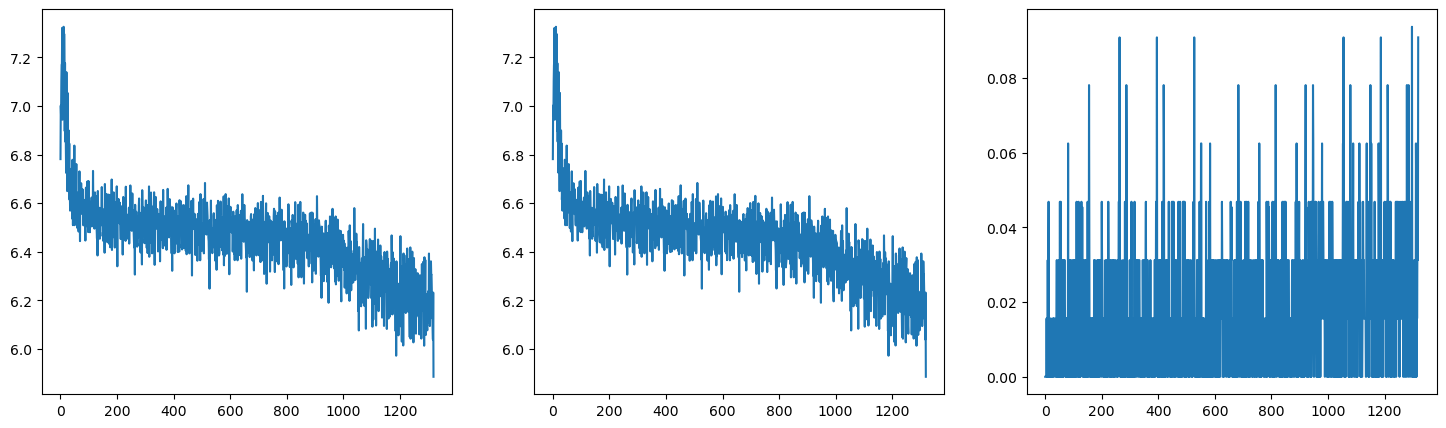

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(mmcr_losses)
axs[1].plot(class_losses)
axs[2].plot(accuracies)



In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(mmcr_losses)
axs[1].plot(class_losses)
axs[2].plot(accuracies)

